In [12]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib import collections
import numpy as np
import pandas as pd

In [ ]:
!wget https://raw.githubusercontent.com/yamnor/rbd-ace2-drin/main/wt_1_ave.pdb
!wget https://raw.githubusercontent.com/yamnor/rbd-ace2-drin/main/wt_rin.fraction
!wget https://raw.githubusercontent.com/yamnor/rbd-ace2-drin/main/om_rin.fraction
!wget https://raw.githubusercontent.com/yamnor/rbd-ace2-drin/main/matplotlibrc

In [13]:
def rcparams(plt, figsize, subplot):
  plt.rcParams["figure.figsize"]        = figsize
  plt.rcParams["figure.subplot.left"]   = subplot['left'] / figsize[0]
  plt.rcParams["figure.subplot.right"]  = 1.00 - subplot['right'] / figsize[0]
  plt.rcParams["figure.subplot.bottom"] = subplot['bottom'] / figsize[1]
  plt.rcParams["figure.subplot.top"]    = 1.00 - subplot['top'] / figsize[1]
  plt.rcParams["figure.subplot.hspace"] = subplot['hspace'] / figsize[1]
  plt.rcParams["figure.subplot.wspace"] = subplot['wspace'] / figsize[0]
  plt.rcParams["axes.grid"] 

figsize = [6.0, 6.0]
subplot = {
  'left':   0.10,
  'right':  0.10,
  'bottom': 0.10,
  'top':    0.10,
  'wspace': 1.50,
  'hspace': 2.00,
  'grid': True,
}

In [27]:
mut = np.array([603, 635, 637, 639, 681, 704, 710, 741, 742, 748, 757, 760, 762, 765, 769]) - 1

In [14]:
xyz = [[float(x) for x in line.split()[5:8]] for line in open('wt_1_ave.pdb', 'r').readlines() if ' CA ' in line]

In [36]:
xy = TSNE(n_components = 2, random_state = 0, perplexity = 60).fit_transform(xyz)[:, ::-1]
xy = np.array([[x[0], x[1]] for x in xy])
node = {'ACE2': xy[0:595].T, 'RBD': xy[596:790].T}

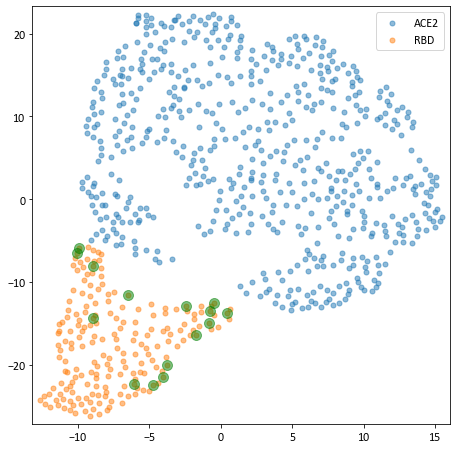

In [37]:
with plt.style.context('matplotlibrc'):
  rcparams(plt, figsize, subplot)
  fig, ax = plt.subplots()
for c in ['ACE2', 'RBD']:
  ax.scatter(*node[c], s = 25, alpha = 0.5, label = c)
for c in mut:
  ax.scatter(*xy[c].T, s = 100, alpha = 0.5, color = 'g')
ax.legend()

In [19]:
rin = ['hb', 'vdw', 'ss', 'ion', 'pp', 'pc', 'iac', 'any']
frac = {}
for sys in ['wt', 'om']:
  frac[sys] = {k: np.zeros((791, 791)) for k in rin}
  tmp = pd.read_table(f'{sys}_rin.fraction')
  for n in range(len(tmp)):
    i = tmp.at[n, 'i'] - 1
    j = tmp.at[n, 'j'] - 1
    for k in rin:
      frac[sys][k][i][j] = tmp.at[n, k]

In [38]:
edge = {'wt':[], 'om':[], 'dif':[]}
for sys in ['wt', 'om']:
  for i, j in [[i, j] for i in range(791) for j in range(791)]: 
    tmp = {k: frac[sys][k][i][j] for k in rin}
    tmp['pos'] = [xy[i], xy[j]]
    edge[sys].append(tmp)

for i, j in [[i, j] for i in range(791) for j in range(791)]: 
  tmp = {k: frac['om'][k][i][j] - frac['wt'][k][i][j] for k in rin}
  tmp['pos'] = [xy[i], xy[j]]
  edge['dif'].append(tmp)

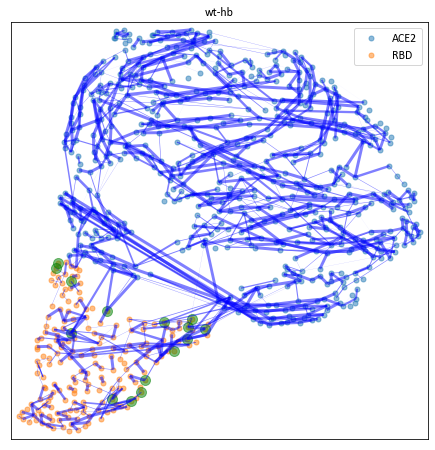

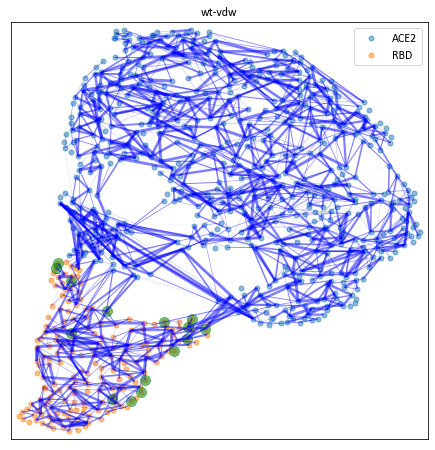

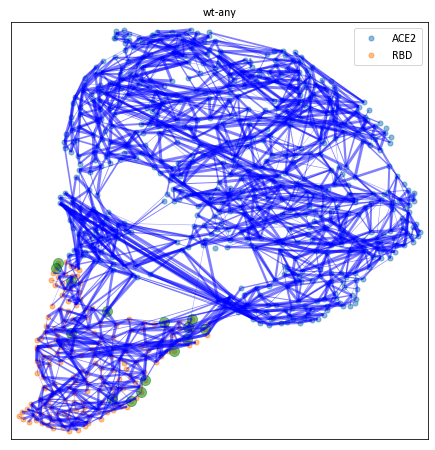

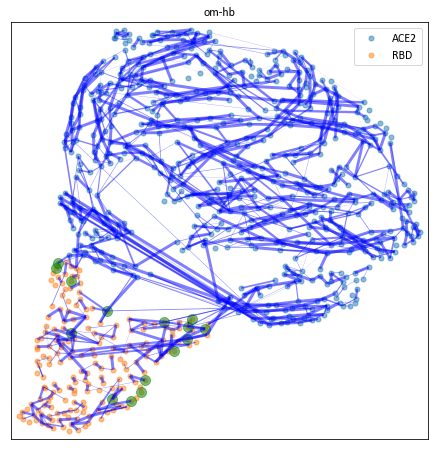

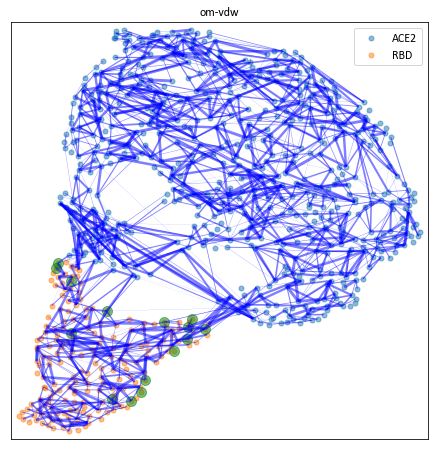

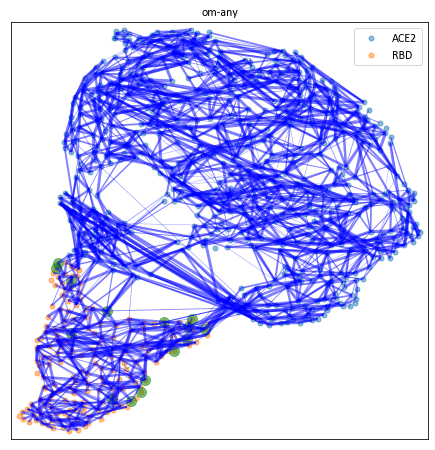

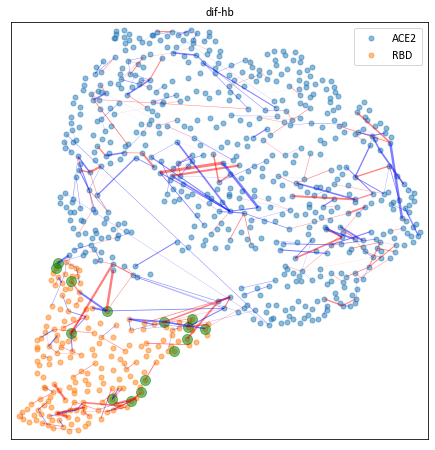

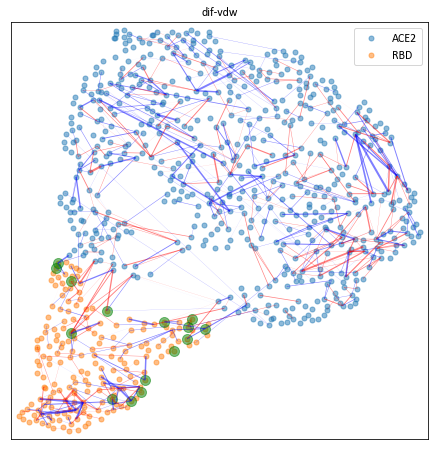

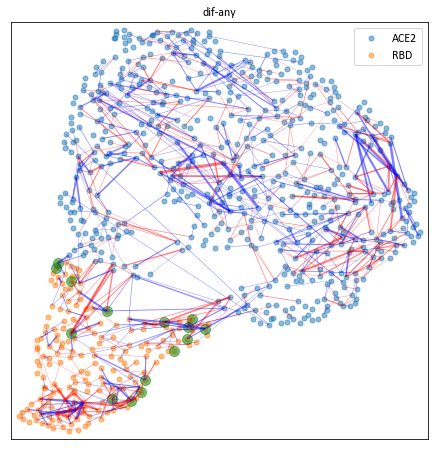

In [39]:
threshold = 0.1

for sys in ['wt', 'om', 'dif']:
  e = [x for x in edge[sys] if abs(x['any']) > threshold]
  pos = [x['pos'] for x in e]
  line = {}
  for k in rin:
    val = np.array([abs(x[k]) for x in e])
    col = ['b' if x[k] > 0.0 else 'r' for x in e]
    line[k] = collections.LineCollection(pos, linewidths = val * 3.0, colors = col, alpha = 0.5)
  for t in ['hb', 'vdw', 'any']:
    with plt.style.context('matplotlibrc'):
      rcparams(plt, figsize, subplot)
      fig, ax = plt.subplots()
    for c in ['ACE2', 'RBD']:
      ax.scatter(*node[c], s = 25, alpha = 0.5, label = c)
    for c in mut:
      ax.scatter(*xy[c].T, s = 100, alpha = 0.5, color = 'g')
    #for n in range(len(xy[0:595])): ax.annotate(n+19, xy = xy[0:595][n], size = 6)
    #for n in range(len(xy[596:790])): ax.annotate(n+333, xy = xy[596:790][n], size = 6)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.add_collection(line[t])
    ax.legend()
    ax.set_title(f'{sys}-{t}')